In [133]:
from scipy.integrate import solve_ivp
import numpy as np
import qpsolvers
from scipy.linalg import block_diag
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt

## Example: Single Pendulum

$$ 
\begin{align*}
\mathbb{L} &= T - V \\
&= \frac{1}{2}ml^2\dot{\theta}^2 + mgl \cos{\theta}
\end{align*}$$

which can be used below to give the 2nd-order ode that governs the dynamics of the system.

$$ 
\begin{align*}
&\frac{d}{dt} \left(  \frac{\partial L}{\partial \dot{\theta}}  \right) -  \frac{\partial L}{\partial \theta} = 0 \\
\implies & ml^2 \ddot{\theta} + mgl \sin{\theta} = 0
\end{align*}$$

Ideally when simulating the control of this system we could actually use a physical copy and the system and use sensors to get state information. In many circumstances this is not possible. Instead we simulate the system.

It is important to note that to do this we are required to work in discrete time-steps and hence approximate the system. The code below illustrates the resulting artifacts.  

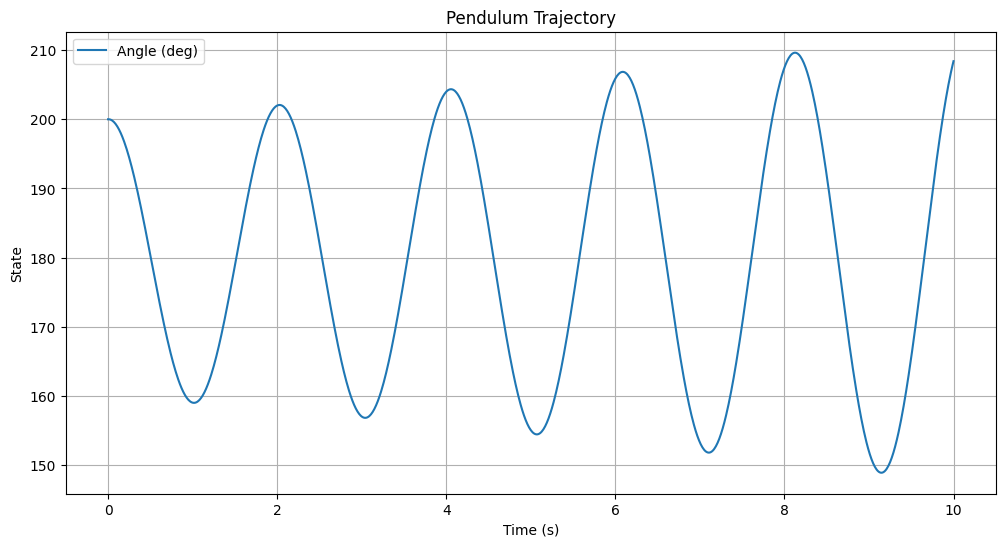

In [134]:
def euler_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot * dt
    return np.array([theta_new, theta_dot_new])


t_span = (0, 10)
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Simulate pendulum trajectory
control_input = np.zeros_like(0.5 * np.sin(t_eval))
theta_start = np.deg2rad(200)
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
trajectory = np.zeros((t_eval.shape[0], 2))
trajectory[0] = x_start

for i in range(1, t_eval.shape[0]):
    trajectory[i] = euler_dynamics(trajectory[i - 1], control_input[i - 1], dt=dt)

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

Here we observe that the first order taylor expansion introduces a violation of the conservation of energy.


$$ \dot{\theta}_{k+1} = \dot{\theta}_k + \ddot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$

$$ \theta_{k+1} = \theta_k + \dot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$






In [135]:
gp = 1 * 9.81 * (1 + np.cos(trajectory[:, 0]))

ke = 0.5 * 1 * trajectory[:, 1] ** 2

total_energy = gp + ke

# Plot the total energy of the pendulum
print(total_energy.max() / total_energy[0])

2.585485423439691


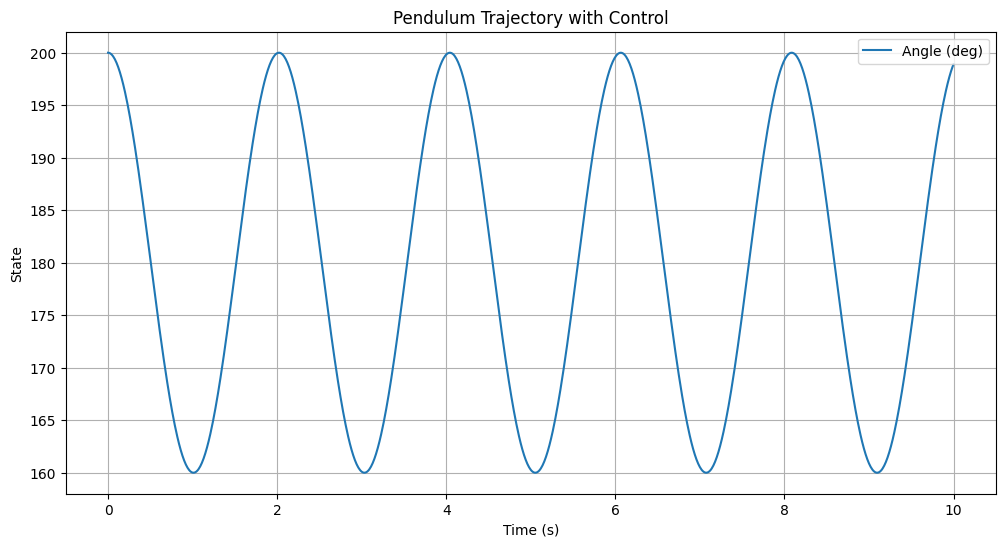

In [136]:
# Define the pendulum dynamics as an ODE with control input
def pendulum_ode(t, y, u, length=1.0, g=9.81):
    theta, theta_dot = y
    theta_ddot = (g / length) * np.sin(theta) + u / (length**2)
    return [theta_dot, theta_ddot]


# Solve the ODE with control input step by step
def solve_pendulum_with_control_step_by_step(t_span, x_start, t_eval, control_input):
    y = np.zeros((len(t_eval), len(x_start)))
    y[0] = x_start
    for i in range(1, len(t_eval)):
        t = t_eval[i - 1 : i + 1]
        u = control_input[i - 1]
        sol = solve_ivp(pendulum_ode, (t[0], t[1]), y[i - 1], args=(u,), t_eval=t)
        y[i] = sol.y[:, -1]
    return t_eval, y


t_eval, solution = solve_pendulum_with_control_step_by_step(
    t_span, x_start, t_eval, control_input
)

# Extract the solution
theta = solution[:, 0]
theta_dot = solution[:, 1]

# Plot the pendulum trajectory
plt.figure(figsize=(12, 6))
plt.plot(t_eval, np.rad2deg(theta), label="Angle (deg)")
plt.title("Pendulum Trajectory with Control")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()

In [137]:
gp = 1 * 9.81 * (1 + np.cos(theta))

ke = 0.5 * 1 * theta_dot**2

total_energy = gp + ke

print(total_energy.max() / total_energy[0])

1.0


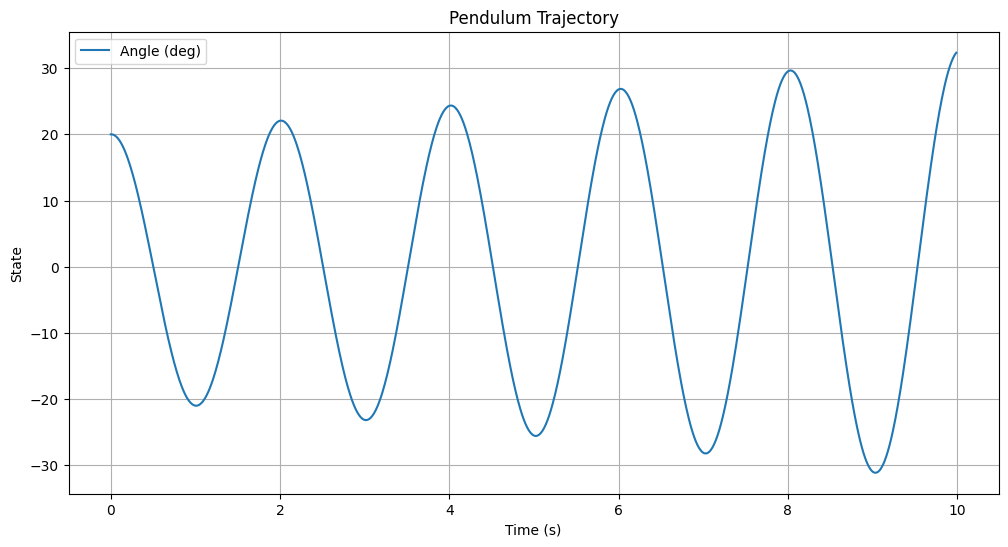

In [138]:
def linearize_pendulum_dynamics(length=1.0, g=9.81, dt=0.01):
    A_cont = np.array([[0, 1], [-g / length, 0]])
    B_cont = np.array([[0], [1 / (length**2)]])

    # Discretize using Euler method
    A_disc = np.eye(2) + A_cont * dt
    B_disc = B_cont * dt
    return A_disc, B_disc


# Simulate pendulum trajectory
theta_start = np.deg2rad(20)  # Convert 5 degrees to radians
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
time = 10  # Number of simulation steps
dt = 0.01  # Time step
steps = int(time / dt)
trajectory = np.zeros((steps, 2))
trajectory[0] = x_start

A, B = linearize_pendulum_dynamics(length=1.0, g=9.81, dt=dt)

for i in range(1, steps):
    u = 0  # 0.5 * np.sin(i * dt)
    trajectory[i] = A @ trajectory[i - 1] + (B * u).flatten()


# Plot the pendulum trajectory
time = np.arange(steps) * dt  # Time array in seconds
plt.figure(figsize=(12, 6))
plt.plot(time, np.rad2deg(trajectory[:, 0]), label="Angle (deg)")
plt.title("Pendulum Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.legend()
plt.grid(True)
plt.show()